In [1]:
# import Pkg
# Pkg.add("DifferentialEquations")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("ModelingToolkit")
# Pkg.add("LSODA")
# Pkg.add("BenchmarkTools")
# Pkg.add("DataFrames")
# Pkg.add("CSV")

In [2]:
using DifferentialEquations # : ODEProblem, solve
using DataFrames: DataFrame
using CSV: File as CSVFile

In [3]:
using Plots
using BenchmarkTools

In [4]:
# using Sundials, LSODA
# using ModelingToolkit

In [5]:
dirname_model = "../src/model_ctypes/ina_pipette/"

filename_legend_constants = Base.Filesystem.joinpath(dirname_model, "legend_constants.csv")
filename_legend_states = Base.Filesystem.joinpath(dirname_model, "legend_test.csv")
filename_protocol = Base.Filesystem.joinpath("../data/protocols/protocol_sparse.csv");

In [6]:
legend_states = DataFrame(CSVFile(filename_legend_states))
legend_constants = DataFrame(CSVFile(filename_legend_constants))
protocol = DataFrame(CSVFile(filename_protocol))

80×2 DataFrame
 Row │ t        v       
     │ Float64  Float64 
─────┼──────────────────
   1 │ 0.0        -80.0
   2 │ 0.00395    -70.0
   3 │ 0.05395    -80.0
   4 │ 0.25395    -70.0
   5 │ 0.30395    -80.0
   6 │ 0.35395    -75.0
   7 │ 0.45395    -80.0
   8 │ 0.50395    -70.0
   9 │ 0.55395    -80.0
  10 │ 0.60395    -70.0
  11 │ 0.70395    -80.0
  ⋮  │    ⋮        ⋮
  71 │ 4.45395    -80.0
  72 │ 4.50395    -70.0
  73 │ 4.55395    -80.0
  74 │ 4.60395     10.0
  75 │ 4.70395    -80.0
  76 │ 4.75395    -70.0
  77 │ 4.80395    -80.0
  78 │ 4.85395     15.0
  79 │ 4.95395    -80.0
  80 │ 4.99995    -80.0
         59 rows omitted

In [7]:
function find_step(t, protocol)
    index = findfirst(x -> x >= t, protocol.t)
    v = protocol.v[index]
end

find_step (generic function with 1 method)

In [8]:
function compute_algebraic(du, u, p, t)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
    
    v_c = p.v_c  # find_step(t)
    
    tau_m = 1 / (p.a0_m * exp(v_m / p.s_m) + p.b0_m * exp(-v_m / p.delta_m))
    tau_h = 1 / (p.a0_h * exp(-v_m / p.s_h) + p.b0_h * exp(v_m / p.delta_h))
    tau_j = p.tau_j_const + 1 / (p.a0_j * exp(-v_m / p.s_j) + p.b0_j * exp(v_m / p.delta_j))
    
    m_inf = 1 / (1 + exp(-(p.v_half_m + v_m) / p.k_m))
    h_inf = 1 / (1 + exp((p.v_half_h + v_m) / p.k_h))
    
    v_cp = v_c + (v_c - v_comp) * (1 / (1 - p.alpha) - 1)

    I_leak = p.g_leak * v_m
    I_Na = p.g_max * h * m^3 * j * (v_m - p.v_rev)
    I_c = 1e9 * p.c_m * ((v_p + p.v_off - v_m) / (p.R * p.c_m) - 1e-9 * (I_leak + I_Na) / p.c_m)
    I_p = 1e9 * p.c_p * (v_cp - v_p) / (p.c_p * p.R_f)
    I_comp = 1e9 * p.x_c_comp * p.c_m * (v_c - v_comp) / (p.x_c_comp * p.c_m * p.x_r_comp * p.R * (1 - p.alpha))
    I_in = I_leak + I_Na + I_c  + I_p - I_comp
    
    a = (tau_m=tau_m, tau_h=tau_h, tau_j=tau_j,
         m_inf=m_inf, h_inf=h_inf,
         v_cp=v_cp, I_leak=I_leak, I_Na=I_Na, I_c=I_c, I_p=I_p, I_comp=I_comp, I_in=I_in,
         v_c=v_c)
    
    return a
end

compute_algebraic (generic function with 1 method)

In [9]:
function compute_rates!(du, u, p, t)
        
    v_comp, v_p, v_m, m, h, j, I_out = u
    a = compute_algebraic(du, u, p, t)
    
    du[1] = (a.v_c - v_comp) / (p.x_c_comp * p.c_m * p.x_r_comp * p.R * (1 - p.alpha))  # v_comp
    du[2] = (a.v_cp - v_p) / (p.c_p * p.R_f)  # v_p
    du[3] = (v_p + p.v_off - v_m) / (p.R * p.c_m) - (1e-9) * (a.I_leak + a.I_Na) / p.c_m  # v_m
        
    du[4] = (a.m_inf - m) / a.tau_m  # m
    du[5] = (a.h_inf - h) / a.tau_h  # h
    du[6] = (a.h_inf - j) / a.tau_j  # j
        
    du[7] = (a.I_in - I_out) / p.tau_z  # I_out
    
    nothing
end

compute_rates! (generic function with 1 method)

In [10]:
function update_p(v_c)
    legend_constants[!, :value][end] = v_c
    p = collect(zip(Symbol.(legend_constants[!, :name]),
                legend_constants[!, :value]))
    p = NamedTuple(p)
end

update_p (generic function with 1 method)

# Callbacks

In [52]:
condition(u, t, integrator) = t ∈ protocol.t

function affect!(integrator)
    t = integrator.t
    v_c = find_step(t, protocol)
    p = update_p(v_c)
    integrator.p = p
    # println(t, v_c)
    # println(get_proposed_dt(integrator))
    set_proposed_dt!(integrator, 1e-9)
    nothing
end

cb = PresetTimeCallback(protocol.t, affect!);

In [53]:
# func = ODEFunction(compute_rates!, syms=[:v_comp, :v_p, :v_m, :m, :h, :j, :I_out])
func = ODEFunction(compute_rates!, syms=[:I_out])

(::ODEFunction{true, typeof(compute_rates!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Vector{Symbol}, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}) (generic function with 7 methods)

In [54]:
u₀ = [-80.0, -80.0, -80.0, 0.0, 1.0, 1.0, 0.0]
tspan = (0., 5.)
p = update_p(-80)

prob = ODEProblem(func, u₀, tspan, p,
                  callback=cb);

In [55]:
saveat = 0: 5e-5: 5
reltol = 1e-9
abstol = 1e-9

sol = solve(prob, alg=Rodas4(), reltol=reltol, abstol=abstol, saveat=saveat, save_idxs=[7]);

In [56]:
sol.alg

Rodas4{7, true, DefaultLinSolve, Val{:forward}}(DefaultLinSolve(nothing, nothing, nothing))

In [16]:
@benchmark solve(prob, alg=sol.alg, reltol=1e-3, abstol=1e-3)

BenchmarkTools.Trial: 231 samples with 1 evaluation.
 Range (min … max):  19.981 ms … 37.602 ms  ┊ GC (min … max): 0.00% … 41.66%
 Time  (median):     21.002 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   21.644 ms ±  2.768 ms  ┊ GC (mean ± σ):  1.91% ±  6.61%

  █▆▄▂▁ ▇▆▃                                                    
  █████████▇▄▆▁▁▄▁▄▁▁▄▄▁▁▁▁▁▁▁▄▁▁▁▁▁▄▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▆▁▁▄ ▆
  20 ms        Histogram: log(frequency) by time      35.7 ms <

 Memory estimate: 3.73 MiB, allocs estimate: 31383.

In [17]:
@benchmark solve(prob, alg=sol.alg, reltol=1e-3, abstol=1e-3, saveat=saveat)

BenchmarkTools.Trial: 104 samples with 1 evaluation.
 Range (min … max):  41.314 ms … 68.475 ms  ┊ GC (min … max): 0.00% … 26.24%
 Time  (median):     47.729 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   48.476 ms ±  7.668 ms  ┊ GC (mean ± σ):  5.50% ±  8.72%

  ▂█▂                                                          
  ███▄▁▁▃▃▃▁▁▁▃▃▄▇▄▆▃▃▅▃▁▁▄▃▃▃▃▁▃▃▃▃▃▃▁▁▁▁▁▁▁▁▃▁▃▁▁▁▁▆▃▃▃▁▁▁▃ ▃
  41.3 ms         Histogram: frequency by time        67.7 ms <

 Memory estimate: 25.36 MiB, allocs estimate: 213859.

In [18]:
@benchmark solve(prob, alg=sol.alg, reltol=1e-3, abstol=1e-3, saveat=saveat, save_idxs=[7])

BenchmarkTools.Trial: 108 samples with 1 evaluation.
 Range (min … max):  42.973 ms … 65.328 ms  ┊ GC (min … max): 0.00% … 25.48%
 Time  (median):     43.955 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   46.548 ms ±  5.215 ms  ┊ GC (mean ± σ):  4.38% ±  8.04%

  ▅█▆                                                          
  ████▃▃▁▄▄▃▃▃▁▃▁▃▁▁▃▁▁▁▁▁▃▁▁▁▁▁▃▃▅▃▃▁▃▃▁▁▁▁▁▁▃▁▁▃▁▁▁▁▁▁▁▁▁▁▃ ▃
  43 ms           Histogram: frequency by time        64.7 ms <

 Memory estimate: 20.78 MiB, allocs estimate: 213861.

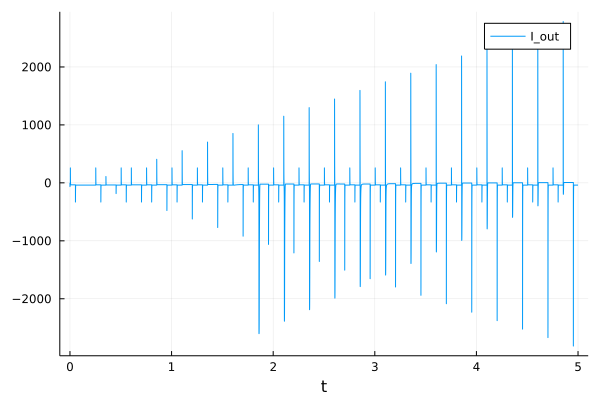

In [59]:
plot(sol, xlim=(-0.1, 5+0.1))

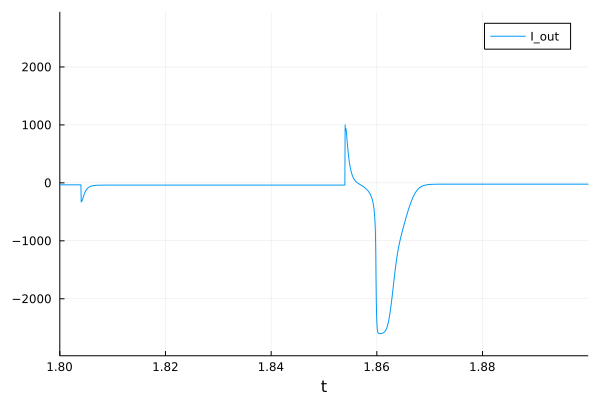

In [57]:
plot(sol)
plot!(xlims=(1.8, 1.9))
# plot!(xlims=(2.8, 2.9))

In [20]:
sol

retcode: Success
Interpolation: 1st order linear
t: 100094-element Vector{Float64}:
 0.0
 5.0e-5
 0.0001
 0.00015
 0.0002
 0.00025
 0.0003
 0.00035
 0.0004
 0.00045
 0.0005
 0.00055
 0.0006
 ⋮
 4.9995
 4.99955
 4.9996
 4.99965
 4.9997
 4.99975
 4.9998
 4.99985
 4.9999
 4.99995
 4.99995
 5.0
u: 100094-element Vector{Vector{Float64}}:
 [0.0]
 [-30.837116111326825]
 [-48.32344753782525]
 [-57.80724168611394]
 [-62.52445880949808]
 [-64.43195195751302]
 [-64.70928156049438]
 [-64.0672588619671]
 [-62.93371962142751]
 [-61.55635246828436]
 [-60.089938957762136]
 [-58.61493959927968]
 [-57.184203755004575]
 ⋮
 [-38.99389190233661]
 [-38.993891900974404]
 [-38.993891899491395]
 [-38.993891897885376]
 [-38.99389189615415]
 [-38.99389189429554]
 [-38.99389189230734]
 [-38.99389189018736]
 [-38.99389188793342]
 [-38.99389188554332]
 [-38.99389188554332]
 [-38.99389188381432]

# Without callbacks

In [21]:
function run_no_callbacks()
    tspan = (0, 0)
    u₀ = [-80.0, -80.0, -80.0, 0.0, 1.0, 1.0, 0.0]
    du = zero(u₀)
    p = update_p(-80)

    for row in eachrow(protocol[2:end, :])
        tspan = (tspan[2], row.t)
        prob = ODEProblem(compute_rates!, u₀, tspan, p)
        sol = solve(prob, alg=Rodas5(), reltol=1e-8, abstol=1e-8)
        p = update_p(row.v)
        u₀ = deepcopy(sol.u[end])
    end
end

run_no_callbacks (generic function with 1 method)

In [22]:
@benchmark run_no_callbacks()

BenchmarkTools.Trial: 37 samples with 1 evaluation.
 Range (min … max):  127.473 ms … 158.633 ms  ┊ GC (min … max): 0.00% … 10.74%
 Time  (median):     134.848 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   136.599 ms ±   8.969 ms  ┊ GC (mean ± σ):  1.72% ±  3.55%

  ▄▄▁ ▁         ▁▁ █                                ▁▁           
  ███▆█▆▆▆▁▆▆▆▁▆██▆█▁▁▁▆▆▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▆▆▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▆ ▁
  127 ms           Histogram: frequency by time          159 ms <

 Memory estimate: 19.71 MiB, allocs estimate: 172779.

In [45]:
tspan = (0, 0)
u₀ = [-80.0, -80.0, -80.0, 0.0, 1.0, 1.0, 0.0]
du = zero(u₀)
p = update_p(-80)

pl = plot()

for row in eachrow(protocol[2:end, :])
    tspan = (tspan[2], row.t)
    prob = ODEProblem(compute_rates!, u₀, tspan, p)
    sol = solve(prob, alg=Rodas5(), reltol=1e-8, abstol=1e-8)
    plot!(sol.t, sol[end, :], label=nothing)
    p = update_p(row.v)
    u₀ = deepcopy(sol.u[end])
end

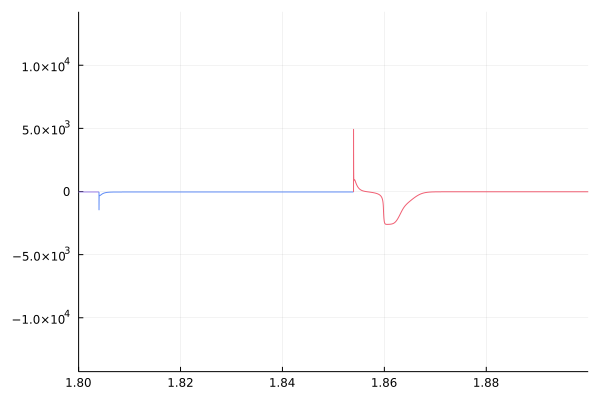

In [46]:
plot!(xlims=(1.8, 1.9))
pl

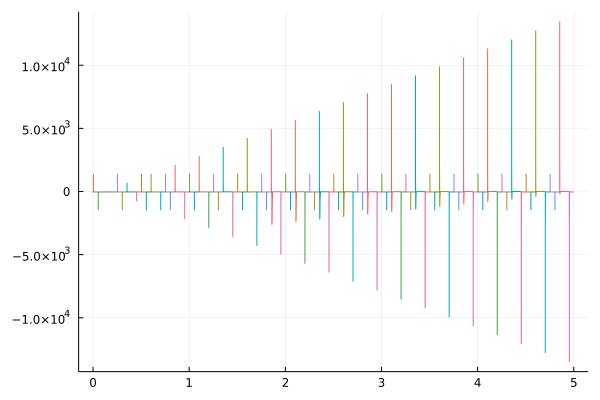

In [25]:
plot!(xlims=nothing)
pl

In [26]:
# I_comp = map(sol) do x
#         a = compute_algebraic(0, x, p, 0)
#         a.I_p
# end